<a href="https://colab.research.google.com/github/StefanDenn3r/LANL-Earthquake-Prediction/blob/master/kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><font size="6">LANL Earthquake EDA and Prediction</font></center></h1>

<h2><center><font size="4">Dataset used: LANL Earthquake Prediction</font></center></h2>

<img src="https://storage.googleapis.com/kaggle-media/competitions/LANL/nik-shuliahin-585307-unsplash.jpg" width="600"></img>

<br>

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Prepare the data analysis</a>  
- <a href='#3'>Data exploration</a>   
- <a href='#4'>Feature engineering</a>
- <a href='#5'>Model</a>
- <a href='#6'>Submission</a>  
- <a href='#7'>References</a>

# <a id='1'>Introduction</a>  

## Simulated earthquake experiment

The data are from an experiment conducted on rock in a double direct shear geometry subjected to bi-axial loading, a classic laboratory earthquake model.

Two fault gouge layers are sheared simultaneously while subjected to a constant normal load and a prescribed shear velocity. The laboratory faults fail in repetitive cycles of stick and slip that is meant to mimic the cycle of loading and failure on tectonic faults. While the experiment is considerably simpler than a fault in Earth, it shares many physical characteristics. 

Los Alamos' initial work showed that the prediction of laboratory earthquakes from continuous seismic data is possible in the case of quasi-periodic laboratory seismic cycles.   

## Competition 

In this competition, the team has provided a much more challenging dataset with considerably more aperiodic earthquake failures.  
Objective of the competition is to predict the failures for each test set.  



# <a id='1'>Preparation</a>

## Load packages

Here we define the packages for data manipulation, feature engineering and model training.

In [46]:
!pip install catboost
!pip install kaggle
!pip install tf-nightly-gpu-2.0-preview
!pip install tensorboard



import gc
import os
import time
import glob
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from pathlib import Path
from zipfile import ZipFile
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
from keras import backend as K
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
import tensorflow as tf


warnings.filterwarnings("ignore")

Connect to Google Drive for accessing kaggle.json file for using kaggle-API.

In [47]:
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

W0320 22:19:31.775918 139761960740736 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Download 100%.


In [48]:
# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook 

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


## Load the data

Load data via kaggle api and afterwards unzip.


In [49]:
%%time

!kaggle competitions download -c LANL-Earthquake-Prediction -p /content/input
ROOT = '/content/input/'

if not os.path.exists(os.path.join(ROOT, "test/")):
  zip_file = ZipFile(os.path.join(ROOT,"test.zip"))
  zip_file.extractall(os.path.join(ROOT,"test/"))
  zip_file.close()
  
if not os.path.exists(os.path.join(ROOT,"train/")):
  zip_file = ZipFile(os.path.join(ROOT,"train.csv.zip"))
  zip_file.extractall(os.path.join(ROOT,"train/"))
  zip_file.close()
  
if not os.path.exists('/content/models'): os.makedirs('/content/models')

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
CPU times: user 29.8 ms, sys: 37.1 ms, total: 66.9 ms
Wall time: 2.51 s


In [50]:
%%time
if not os.path.exists(os.path.join(ROOT,"train/train_df")):
  train_df = pd.read_csv(os.path.join(ROOT,'train/train.csv'), dtype={'acoustic_data': np.int32, 'time_to_failure': np.float32})
  train_df.to_pickle(os.path.join(ROOT, "train/train_df"))
else: 
  train_df = pd.read_pickle(os.path.join(ROOT, "train/train_df"))

CPU times: user 2min 33s, sys: 24.2 s, total: 2min 57s
Wall time: 3min 10s


Let's check the data imported.

In [51]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))

Train: rows:629145480 cols:2


In [52]:
pd.options.display.precision = 15
train_df.head(10)

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121
5,8,1.469099998474121
6,9,1.469099998474121
7,7,1.469099998474121
8,-5,1.469099998474121
9,3,1.469099998474121


# <a id='3'>Data exploration</a>  

The dimmension of the data is quite large, in excess of 600 millions rows of data.  
The two columns in the train dataset have the following meaning:   
*  accoustic_data: is the accoustic signal measured in the laboratory experiment;  
* time to failure: this gives the time until a failure will occurs.

Let's plot 1% of the data. For this we will sample every 100 points of data.  

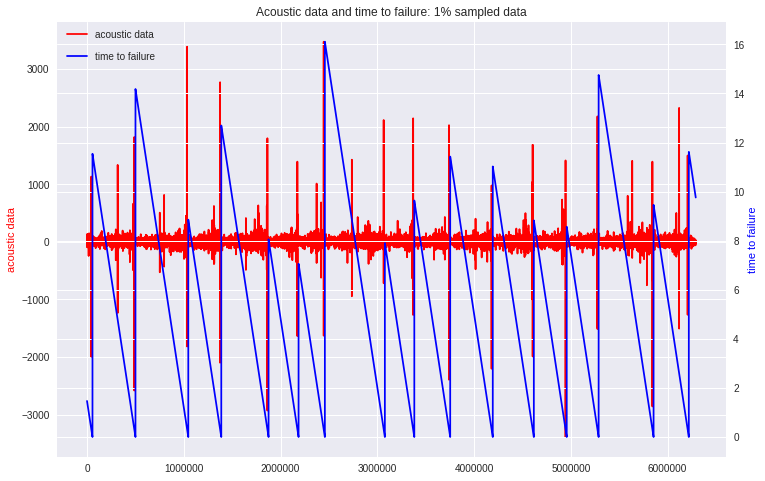

In [53]:
train_ad_sample_df = train_df['acoustic_data'].values[::100]
train_ttf_sample_df = train_df['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

The plot shows only 1% of the full data. 
The acoustic data shows complex oscilations with variable amplitude. Just before each failure there is an increase in the amplitude of the acoustic data. We see that large amplitudes are also obtained at different moments in time (for example about the mid-time between two succesive failures).  

Let's plot as well the first 1% of the data.

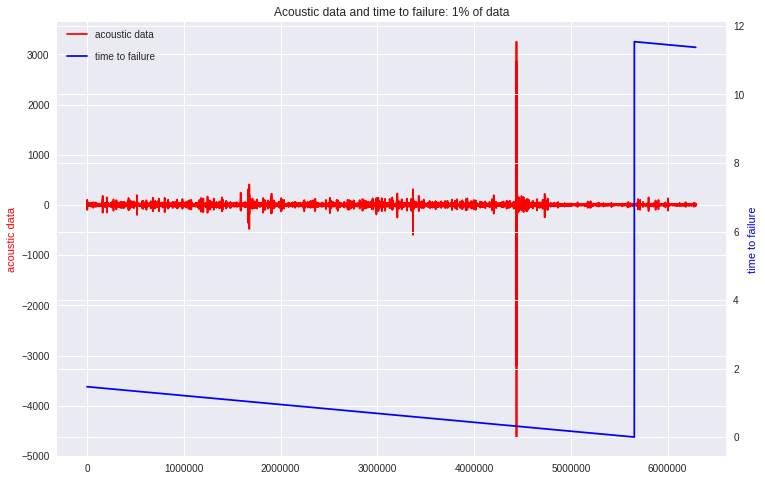

In [54]:
train_ad_sample_df = train_df['acoustic_data'].values[:6291455]
train_ttf_sample_df = train_df['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% of data")
del train_ad_sample_df
del train_ttf_sample_df

On this zoomed-in-time plot we can see that actually the large oscilation before the failure is not quite in the last moment. There are also trains of intense oscilations preceeding the large one and also some oscilations with smaller peaks after the large one. Then, after some minor oscilations, the failure occurs.

# <a id='4'>Features engineering</a>  

The test segments are 150,000 each.   
We split the train data in segments of the same dimmension with the test sets.

We will create additional aggregation features, calculated on the segments. 


In [55]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


## Process train file

Reshape DataFrame so that on acoustic_data is considered as features and each row represents one sample with 150000 features

In [0]:
train_X = pd.DataFrame(np.reshape(train_df.loc[:(segments*rows)-1, 'acoustic_data'].values, (segments, rows)))
train_Y = train_df.loc[rows::rows, 'time_to_failure']

del train_df

In [0]:
train_X.head(10)

## Check submission file


In [0]:
submission = pd.read_csv(os.path.join(ROOT, 'sample_submission.csv'), index_col='seg_id')
submission.head(10)


# <a id='5'>Model</a>  

Let's prepare the model.

## Run model

We define the folds for cross-validation.

In [0]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)


In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense, Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

def create_model():
  return Sequential([
    LSTM(64),
    BatchNormalization(),
    Dense(1)
  ])

In [0]:
def create_and_train_model(X_tr, X_val, y_tr, y_val):
    model = create_model()
    model.compile(loss='mean_absolute_error', optimizer='adam')
    
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
 
    
    model.fit(X_tr,
                y_tr,
                epochs=1,
                verbose=True,
                validation_data=(X_val, y_val),
                callbacks=[
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto'),
                    ModelCheckpoint('/content/models/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1),
                    TensorBoard(logdir, histogram_freq=1)
                  ]
             )
    return model

## Predicting test in batches
Test files are in total to big to fit on GPU, so loading them in batches, predicting and afterwards deleting those objects.

In [0]:
test_paths = glob.glob(os.path.join(ROOT, "test/*.csv"))

def predict_in_batches(model, test_batch_size=16):
    batches = [test_paths[i:i+test_batch_size] for i in range(0, len(test_paths), test_batch_size)]
    for batch in batches:
      X_test = pd.concat([pd.read_csv(f) for f in batch], axis=1, ignore_index=True).T.values
      reshaped_X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
      predictions = model.predict(reshaped_X_test) / folds.n_splits
      for (i, f) in enumerate(batch): 
        submission.loc[Path(f).stem, 'time_to_failure'] += predictions[i]
      del reshaped_X_test


In [44]:
#X_tr, X_val = tf.convert_to_tensor(train_X.values[0:5], dtype=tf.float32),  tf.convert_to_tensor(train_X.values[0:5], dtype=tf.float32)
#y_tr, y_val = train_Y.values, train_Y.values

#X_tr = np.reshape(X_tr, (X_tr.shape[0], 1, X_tr.shape[1]))
#X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

#create_and_train_model(X_tr, X_val, y_tr, y_val)   

Train on 5 samples, validate on 5 samples


W0320 22:15:40.213555 139761960740736 tf_logging.py:161] Trace already enabled


5/5 [==============================] - 1s 250ms/sample - loss: 2.1159 - val_loss: 1.4958


We run the model. During training for each fold, we validate using the validation set and also we predict using the current model for test set. The final result will be the average over the all folds for the predictions done at each fold training.

In [45]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X,train_Y.values)):
    print("fold {}".format(fold_))
    
    X_tr, X_val = tf.convert_to_tensor(train_X.iloc[trn_idx].values, dtype=tf.float32), tf.convert_to_tensor(train_X.iloc[val_idx].values, dtype=tf.float32)
    y_tr, y_val = train_Y.iloc[trn_idx].values, train_Y.iloc[val_idx].values
  
    X_tr = np.reshape(X_tr, (X_tr.shape[0], 1, X_tr.shape[1]))
    X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
    create_and_train_model(X_tr, X_val, y_tr, y_val)   

ValueError: ignored

In [0]:
predict_in_batches(model)


## Features importance

Let's print features importance.

# <a id='6'>Submission</a>  

We set the predicted time to failure in the submission file.

In [0]:
submission.to_csv('submission.csv',index=True)